## Example jupyter notebook to look at CAM-MPAS output (history file) on the unstructured MPAS mesh (SCVT grid)

Prepared for the submitted manuscript 'FACETS Dynamical Downscaling Simulations over North America by the CAM-MPAS Variable-Resolution Model'  by Sakaguchi et al.


In [1]:
#useful python modules
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import os


### Set parameters for the region of interest

In [69]:
targetarea = 'CONUS' #give it a name
#define regional lat/lon indices (example for CONUS domain)
#longitude is 0-360 
lonmin =  255.0 #-105 + 360.0
lonmax = 275.0 #-85 + 360.0
latmin = 30.0
latmax = 47.0

#whhere data files are located
workdir = '/global/cfs/cdirs/m2645/www/pnnl/examples'

os.chdir(workdir)


### Load MPAS grid information

In [70]:
#CAM-MPAS history files usually store lat and lon coodrinates, but not gridcell area
#that can be used as weight for regional average
#so read the "grid_fx*" file to get such grid information

domfile= './grid_fx.VR50-200.cam54-mpas4.v3.nc'
ds_dom = xr.open_dataset(domfile)

lat = ds_dom['lat']
lon = ds_dom['lon']
             
#grid cell area as weighting - either one works
areacell_km = ds_dom['areacell_km']
#areacell_rad = ds_dom['areacell_rad']

#if we want to mask out certain gridcells over ocean
landmask = ds_dom['landmask'] 

ds_dom.close()

### Open CAM-MPAS history file

In [71]:
#history file path
histfile = './mp34306a_prod05_FA54.cam.h2.2000-06-01-00000.nc'

#choose variable to plot
varname = 'TMQ' #precipitable water

ds_hist = xr.open_dataset(histfile)

#### sub-select the grid columns within the analysis domain

In [72]:
#read only the grid boxes within the specified lat/lon limits

itemp = ds_hist[varname].where((lat <= latmax) & (lat >=latmin) 
                               & (lon >= lonmin) & (lon <= lonmax), drop = True)

#create with the same dimension as the variable to be averaged 
#not needed for later versions of xarray that has weight-average function
#for MPAS's quasi-uniform grid cells, such a weighting may not be really necessary
#unless the analysis domain cross the transition zone on a variable-resolution mesh
atemp = areacell_km.where((lat <= latmax) & (lat >=latmin) 
                       & (lon >= lonmin) & (lon <= lonmax), drop = True)

_, area_alldims = xr.broadcast(itemp,atemp) 
#add time and other dimensions lacking in the areacell variable by broadcast function
#to conform with the dimensions of the variable of interest
#xr.broadcast returns two datasets as tubple. 
#Only need the second one corresponding to area
#https://nordicesmhub.github.io/NEGI-Abisko-2019/training/Example_model_global_arctic_average.html

#area-weighted average 
wtemp = itemp*area_alldims
wtempsum = wtemp.sum(dim=('ncol'))
area_tot = area_alldims.where(itemp.notnull()).sum(dim=('ncol'))
area_avg_wgt =  wtempsum / area_tot

In [73]:
#or any other statistics over the analysis sub-domain
area_avg = np.nanmean(itemp.values,axis=1)
area_std = np.nanstd(itemp.values,axis=1)
area_max = np.nanmax(itemp.values,axis=1)
area_min = np.nanmin(itemp.values,axis=1)


### A couple of example plots

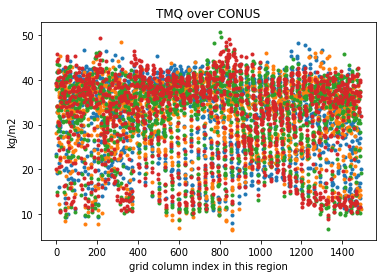

In [74]:
#and line/marker plot as a function gridicell index
ncol = itemp.sizes['ncol']
ntime = itemp.sizes['time']

xcol = np.arange(0,ncol)

for it in range(0,ntime):
    _=plt.plot(xcol,itemp[it,:],'.')
    
_ = plt.title(varname + ' over ' + targetarea)
_ = plt.ylabel(itemp.attrs['units'])
_ = plt.xlabel('grid column index in this region')

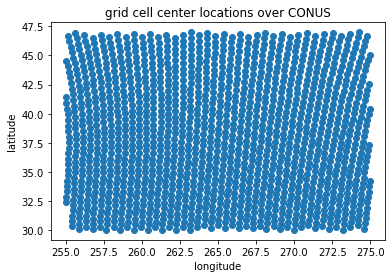

In [68]:
#lat/lon scatter plots for each grid cell cener
lat_regional = lat.where((lat <= latmax) & (lat >=latmin) 
                       & (lon >= lonmin) & (lon <= lonmax), drop = True)
lon_regional = lon.where((lat <= latmax) & (lat >=latmin) 
                       & (lon >= lonmin) & (lon <= lonmax), drop = True)

_=plt.scatter(lon_regional,lat_regional)
_ = plt.ylabel('latitude')
_ = plt.xlabel('longitude')
_ = plt.title('grid cell center locations over ' + targetarea)
